# Задание 03-04

In [1]:
import numpy as np
from ipywidgets import interact
import random
from tqdm.notebook import tqdm
import re
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import seaborn as sns

%matplotlib inline

### Задача 1.  Эволюция графа Эрдеша-Реньи и фазовый переход
Напишите программу эволюции случайного графа Эрдеша-Реньи $G(N,t)$: 
* создайте пустой граф с $N$ вершинами,
* добавляйте случайным образом ребра по одному,
* при каждом добавлении вычисляйте (и записывайте) размер гигантской компоненты;
* постройте зависимость размера гигантской компоненты (число вершин, входящих в $GC$) от времени $t$. Видите ли вы рождение гигантской компоненты? При каком $t$ (числе ребер) он происходит?

$N=500,t_{max}=500.$ 

In [2]:
N, t_max = 500, 500

In [3]:
def ER_graph(N, t):
    G = nx.Graph(np.zeros(shape=(N,N), dtype=int))
    nodes = list(G.nodes())
    GC_size = []
    for i in range(t):
        edge = random.sample(nodes, 2)
        G.add_edge(*edge)
        GC = max(nx.connected_components(G), key=len)
        GC_size.append(len(GC))        
    return G, GC_size

In [4]:
G, GC_size = ER_graph(N, t_max)

t_born = np.diff(GC_size).argmax()+1
s_born = GC_size[t_born]
print('Number of nodes (appr.) at which Giant Component is born: {}'.format(t_born))

Number of nodes (appr.) at which Giant Component is born: 240


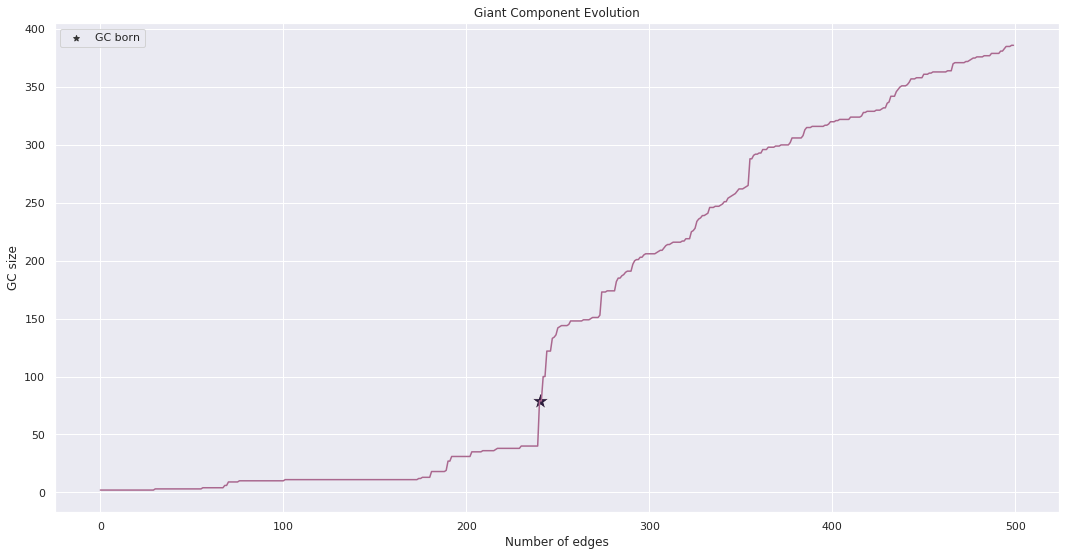

In [5]:
fig = plt.figure(figsize=(18, 9))
sns.set(style="darkgrid")
pal = sns.palettes.cubehelix_palette(2, light=0.5)
sns.lineplot(range(t_max), GC_size, color=pal[0])
sns.scatterplot(x=[t_born], y=[s_born], style=['GC born'], markers=["*"], s=[320], color=pal[-1])
plt.title('Giant Component Evolution')
plt.xlabel('Number of edges') 
plt.ylabel('GC size')
plt.savefig('Kim_1.png')
plt.show()

For $p=p_{c}={\frac {1}{n}}$
[...] the number of vertices in the largest component of the graph is with high probability proportional to $n^{2/3}$.

### Задача 2. Малый мир сложных сетей.  

* напишите функцию, оценивающую средний кратчайший путь в сети: для $M$ случайно выбранных пар вершин вычислите длины кратчайших путей и посчитайте среднее значение на этой выборке;


In [6]:
def estimated_average_path(G, M):
    N = G.number_of_nodes()
     
    paths = []
    nodes = list(G.nodes())
    u, v = random.sample(nodes, 2)
    for i in range(M):
        while not nx.has_path(G, u, v):
            u, v = random.sample(nodes, 2)
        paths.append(nx.shortest_path_length(G, u, v))
    return np.mean(paths)

In [7]:
print('Estimated average path length: {}'.format(estimated_average_path(G, 1000)))

Estimated average path length: 6.0


* напишите функцию, определяющую меру малого мира сети [$\bf\sigma$](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002051):
$$
\sigma=\frac{C/C_r}{L/L_r},
$$
где $C$ и $C_r$ - коэффициенты кластеризации сети и случайного графа Эрдеша-Реньи с теми же параметрами ($N,<k>$),что и в изучаемой сети, и $L$, $L_r$ - значения cреднего кратчайшего пути сети и случайного графа Эрдеша-Реньи. Значения характеристик для случайного графа вычислите аналитически:

$$
C_r(N,k)=\frac{<k>}{N},
$$
[$$
L_r(N,k)=\frac{\ln N-\gamma}{\ln <k>}+\frac{1}{2},
$$](https://arxiv.org/abs/cond-mat/0212230)
где $\gamma \approx 0.5772$ - [константа Эйлера](https://ru.wikipedia.org/wiki/%D0%9F%D0%BE%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%BD%D0%B0%D1%8F_%D0%AD%D0%B9%D0%BB%D0%B5%D1%80%D0%B0_%E2%80%94_%D0%9C%D0%B0%D1%81%D0%BA%D0%B5%D1%80%D0%BE%D0%BD%D0%B8). 



In [8]:
def listDegrees(G):
    return [d for n, d in G.degree()]
eulers_gamma = 0.5772

In [9]:
def small_world_coef(G): 
    N = G.number_of_nodes()
    k = np.mean(listDegrees(G))
    
    L = estimated_average_path(G, 1000)
    Lr = (np.log(N) - eulers_gamma)/np.log(k) + 0.5
    
    C = nx.average_clustering(G)
    Cr = k/N
    sigma = (C/Cr) / (L/Lr)
    
    return sigma

* для заданных сетей оцените средний кратчайший путь в сети, сравните это значение с $\ln N$ и вычислите меру малого мира $\sigma$, результаты представьте в таблице:

In [10]:
def parseEdgelist(path):
    with open(path, mode='r') as f:
        if len(f.readline().split())==2:
            lines = [l.split() for l in f.readlines()]
        else:
            lines = [[s.strip() for s in re.split('[,\t]', l)] for l in f.readlines()]
    return nx.from_edgelist(lines)

In [11]:
tables = glob.glob('../data/*.*')
graphs = [parseEdgelist(table) for table in tqdm(tables)]

In [12]:
def graphsToDataFrame(graphs, tables):
    cols=['nodes', 'edges', 'avg-path', 'ln-n', 'clustering-coef', 'small-world-measure']
    
    df = pd.DataFrame(columns=cols, index=range(len(graphs)))
    
    df.index = ['_'.join(os.path.basename(t).split('.')[:-1]) for t in tables]
    df["nodes"] = [g.number_of_nodes() for g in graphs]
    df["edges"] = [g.number_of_edges() for g in graphs]
    df["avg-path"] = [estimated_average_path(g, 1000) for g in graphs]
    df["ln-n"] = df['nodes'].apply(np.log)
    df["clustering-coef"] = [nx.average_clustering(g) for g in graphs]
    df["small-world-measure"] = [small_world_coef(g) for g in graphs]
    
    return df

In [13]:
data = graphsToDataFrame(graphs, tables)

### Задача 3. Устойчивость малого мира сложных сетей. 

* Напишите функцию, удаляющую $10\%$ случайно выбранных ребер;

* посмотрите, как изменятся характеристики, определяющие малый мир сети после удаления $10 \% $ ребер:
средний путь, коэффициент кластеризации, мера малого мира. Результаты добавьте в таблицу выше.


In [14]:
def pruning(G, p=0.1):
    edges = list(G.edges())
    q = round(len(edges)*p)
    bunch = random.sample(edges, q)
    G.remove_edges_from(bunch)
    return G

In [15]:
tables_pruned = list(map(lambda x : '.pruned.'.join(x.split('.')), tables))
graphs_pruned = [pruning(g) for g in graphs]
data = data.append(graphsToDataFrame(graphs_pruned, tables_pruned))

In [16]:
@interact
def showDf(col=data.columns):
    def highlight_cols(s):
        color = sns.cubehelix_palette(start=2.8, rot=.1, n_colors=20).as_hex()[data.columns.get_loc(col)]
        return 'background-color: %s' % color
    return data.sort_values(by=col, ascending=True).style.applymap(highlight_cols, subset=pd.IndexSlice[:, [col]])

interactive(children=(Dropdown(description='col', options=('nodes', 'edges', 'avg-path', 'ln-n', 'clustering-c…